<a href="https://colab.research.google.com/github/ninoc0/Research/blob/main/ResonantGainCurveFit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This first cell is so you can view what the curve fitting data looks like. The actual code(viewed in its best form) is avaliable on [gitlab](https://gitlab.com/syracuse_experimental_gravity/circuit_analysis/-/blob/main/code/HighPassCurveFit.py?ref_type=heads). **Do not** click run on the code, scroll down and take a look at the graph. By re-running the code, it would require you to have my data file :)

# Circuit Diagram
<p align=center>
<img src="https://drive.google.com/uc?export=view&id=1tJKlwjsDzH9uAiVbf8xKEMg3h0VGhiTX" width="550" height="350">
</p>




# Curve Fit & Residuals Plots

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-3-e41df97ceb94>:20: RuntimeWarning: invalid value encountered in sqrt
  omega0 = 1 / np.sqrt(L * C)
<ipython-input-3-e41df97ceb94>:21: RuntimeWarning: invalid value encountered in sqrt
  Q = 1 / R * np.sqrt(L / C)


Parameters
[10, 0.0001, 1e-06]
[1.14342785e+01 1.09401927e-04 8.09525843e-07]

[125663.70614359173, 0.5]
[1.06260560e+05 1.01668839e+00]


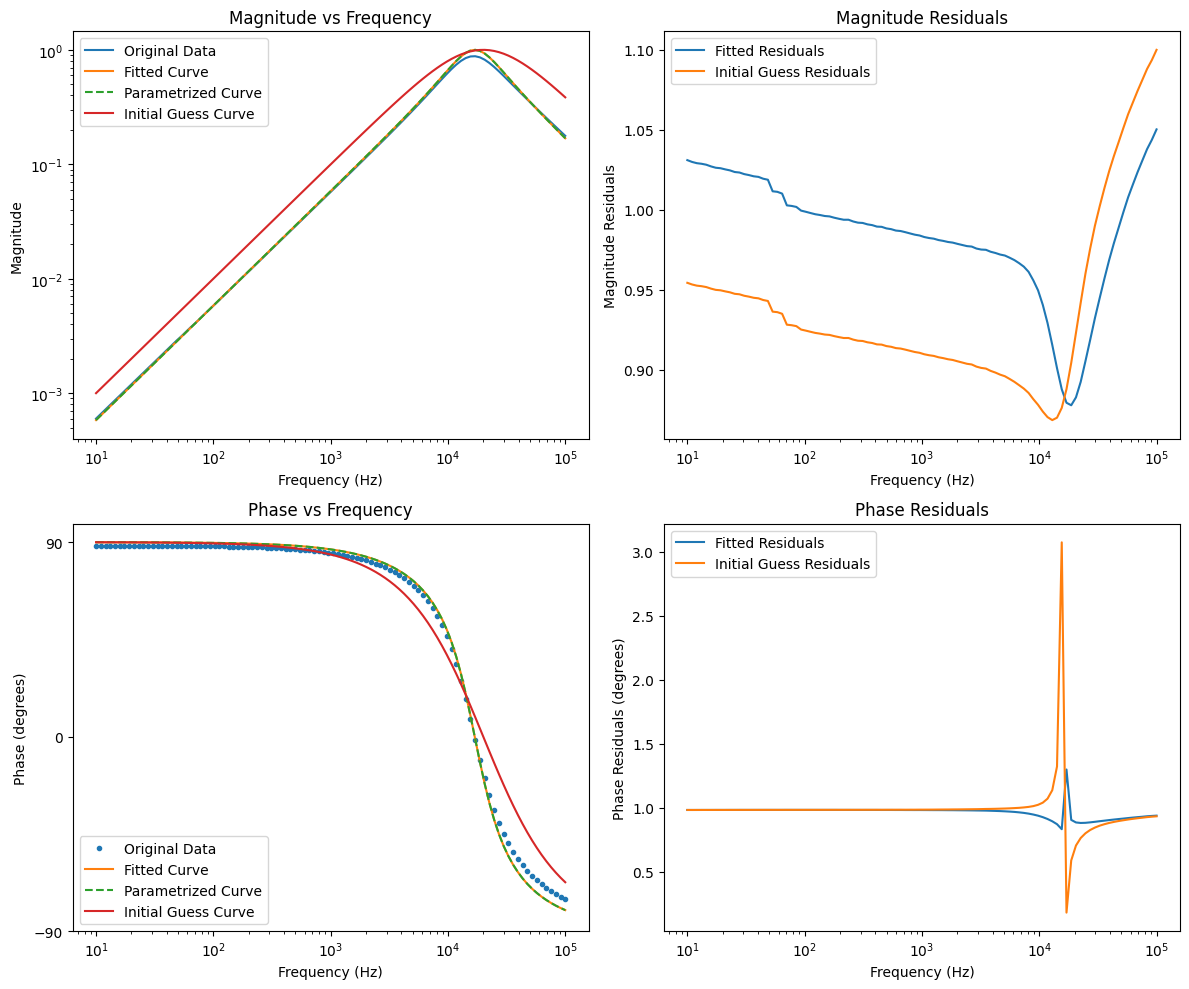

In [3]:
#@title .
from google.colab import drive #connects drive to import data
drive.mount('/content/drive')
import pandas as pd
# Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Data File
df = pd.read_excel('/content/drive/My Drive/code/ResG_data.xlsx')

frequency = df['Frequency (Hz)'].values
magnitude = df['Magnitude'].values
phase = df['Phase'].values

# Defines the transfer function
def general_transfer_func(f, R, L, C):
    omega = 2 * np.pi * f
    omega0 = 1 / np.sqrt(L * C)
    Q = 1 / R * np.sqrt(L / C)
    # transfer = (1j * omega * omega0 / Q) / ((1j * omega * omega0 / Q)+omega0**2 - omega**2)
    transfer = (1j * omega * R *C) / (1 + 1j* omega*R*C - omega**2*L*C)

    real = np.real(transfer)
    imag = np.imag(transfer)

    tf = np.concatenate((real, imag))
    return tf

def parametrize_tf(f, omega0, QQ):
    omega = 2 * np.pi * f

    transfer = (1j * omega * omega0 / QQ) / ((1j * omega * omega0 / QQ) + omega0**2 - omega**2)

    real = np.real(transfer)
    imag = np.imag(transfer)

    tf = np.concatenate((real, imag))
    return tf


# Determines the measured transfer function
meas_tf = magnitude * np.exp(1j * np.pi * phase / 180)
real_meas_tf = np.real(meas_tf)
imag_meas_tf = np.imag(meas_tf)
curve_fit_meas_tf = np.concatenate((real_meas_tf, imag_meas_tf))

# Curve Fit
p0 = [10, 1e-4, 1e-6]
popt_general, pcov = curve_fit(general_transfer_func, frequency, curve_fit_meas_tf, p0=p0)

# Curve Fit Parametrized
pp0 = [2*np.pi*2e4, 0.5]
popt_parametrize, pcov_parametrize = curve_fit(parametrize_tf, frequency, curve_fit_meas_tf, p0=pp0)

# #Debugging
#print (len(frequency))
#print (len(curve_fit_meas_tf))
#print (len(general_transfer_func(frequency, *popt_general)))
#print(popt_general)

R, L, C = popt_general
omega_0, QQ0 = popt_parametrize

print("Parameters")
print(p0)
print(popt_general)
print()
print(pp0)
print(popt_parametrize)

init_tf = general_transfer_func(frequency, *p0)
init_param_tf = parametrize_tf(frequency, *pp0)
fitted_tf = general_transfer_func(frequency, *popt_general)
fitted_param_tf = parametrize_tf(frequency, *popt_parametrize)

init_tf = [init_tf[i]+1j*init_tf[i+len(frequency)] for i in range(len(frequency))]
init_param_tf = [init_param_tf[i]+1j*init_param_tf[i+len(frequency)] for i in range(len(frequency))]
fitted_tf = [fitted_tf[i]+1j*fitted_tf[i+len(frequency)] for i in range(len(frequency))]
fitted_param_tf = [fitted_param_tf[i]+1j*fitted_param_tf[i+len(frequency)] for i in range(len(frequency))]

# Plots !!
fig, ((s1, s3), (s2, s4)) = plt.subplots(2, 2, figsize=(12, 10))
s1.loglog(frequency, magnitude, label='Original Data')
s1.loglog(frequency, np.abs(fitted_tf), label='Fitted Curve')
s1.loglog(frequency, np.abs(fitted_param_tf), '--', label='Parametrized Curve')
s1.loglog(frequency, np.abs(init_param_tf), label='Initial Guess Curve')

s1.set_xlabel('Frequency (Hz)')
s1.set_ylabel('Magnitude')
s1.set_title('Magnitude vs Frequency')
s1.legend()

s2.semilogx(frequency, phase, '.', label='Original Data')
s2.semilogx(frequency, np.angle(fitted_tf, deg=True), label='Fitted Curve')
s2.semilogx(frequency, np.angle(fitted_param_tf, deg=True), '--', label='Parametrized Curve')
s2.semilogx(frequency, np.angle(init_param_tf, deg=True), label='Initial Guess Curve')

s2.set_xlabel('Frequency (Hz)')
s2.set_ylabel('Phase (degrees)')
s2.set_title('Phase vs Frequency')
s2.set_yticks([-90, 0, 90])
s2.legend()

# Calculate residuals for magnitude
residuals_fittedmag = magnitude/np.abs(fitted_tf)
residuals_initmag = magnitude/np.abs(init_tf)

# Calculate residuals for phase
residuals_fittedphase = phase/np.angle(fitted_tf, deg=True)
residuals_initphase = phase/np.angle(init_tf, deg=True)

# Residual plot for magnitude
s3.semilogx(frequency, residuals_fittedmag, label='Fitted Residuals')
s3.semilogx(frequency, residuals_initmag, label='Initial Guess Residuals')
s3.set_xlabel('Frequency (Hz)')
s3.set_ylabel('Magnitude Residuals')
s3.set_title('Magnitude Residuals')
s3.legend()

# Residual plot for phase
s4.semilogx(frequency, residuals_fittedphase, label='Fitted Residuals')
s4.semilogx(frequency, residuals_initphase, label='Initial Guess Residuals')
s4.set_xlabel('Frequency (Hz)')
s4.set_ylabel('Phase Residuals (degrees)')
s4.set_title('Phase Residuals')
s4.legend()

plt.tight_layout()
plt.show()
